In [3]:
# Importação de bibliotecas

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

In [4]:
# Conexão entre o Google Colab e o Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Criação de função para o pré-processamento dos dados
# A execução de todas as funções será realizada na última célula

def load_and_preprocess_data(filepath, start_date, end_date):
    # Leitura do conjunto de dados
    df = pd.read_csv("/content/drive/MyDrive/CEPEA.csv")

    # Renomeação das colunas de preço
    df.rename(columns={
        'valor_reais': 'preco_reais',
        'valor_dolares': 'preco_dolares'
    }, inplace=True)

    # Conversão da coluna 'data' para o formato datetime
    df['data'] = pd.to_datetime(df['data'], format='%d/%m/%Y', dayfirst=True, errors='coerce')

    # Filtragem dos dados para o período desejado
    df = df[(df['data'] >= start_date) & (df['data'] <= end_date)]

    # Ordenação ascendente dos dados pela coluna 'data'
    df.sort_values(by='data', ascending=True, inplace=True)

    # Redefinição do índice do conjunto de dados
    df.reset_index(drop=True, inplace=True)

    return df

In [6]:
# Visualização dos dados
def plot_data(df):
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(16, 8))
    sns.lineplot(x="data", y="preco_reais", data=df, color="#8c94d7", linewidth=2)
    plt.title("Preços de Café Arábica no Brasil", fontsize=16, fontweight="bold", color="#333333")
    plt.xlabel("Ano", fontsize=14, color="#333333")
    plt.ylabel("Preço (R$)", fontsize=14, color="#333333")
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(visible=True, color="#dddddd", linestyle="--", linewidth=0.7)
    plt.show()

In [7]:
# Preparação dos dados para o LSTM
def prepare_data(df, column, window_size, train_split=0.8):
    # Extração dos dados da coluna desejada ('preco_reais')
    price = df[[column]].values

    # Normalização dos dados em uma escala 0-1
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(price)

    # Divisão dos dados para treinamento (80%) e teste (20%) do modelo
    train_size = int(len(scaled_data) * train_split)
    train_data = scaled_data[:train_size]
    test_data = scaled_data[train_size - window_size:]

    # Criação das sequências de dados para o LSTM
    def create_sequences(data, window_size):
        X, y = [], []
        for i in range(window_size, len(data)):
            X.append(data[i - window_size:i, 0])  # Coletar 'window_size' passos de dados para X
            y.append(data[i, 0])  # O próximo valor (target) para y
        return np.array(X), np.array(y)

    # Criação sequências para dados de treinamento e teste
    X_train, y_train = create_sequences(train_data, window_size)
    X_test, y_test = create_sequences(test_data, window_size)

    # Remodelação dos dados para o formato 3D conforme exigido pelo LSTM (amostras, passos_de_tempo, características)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train, X_test, y_test, scaler

In [8]:
# Construção do modelo LSTM multicamadas
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(units=512, return_sequences=True, activation='relu', input_shape=input_shape),
        Dropout(0.2),
        LSTM(units=256, return_sequences=False, activation='relu'),
        Dropout(0.2),
        Dense(units=1)
    ])
    model.compile(optimizer="adam", loss="mean_squared_error", metrics=['mae'])
    return model

In [9]:
# Definição de EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',     # Pode ser 'loss' se não usar validação
    patience=5,             # Para de treinar se não melhorar por 5 épocas
    restore_best_weights=True  # Volta para o melhor modelo
)

In [10]:
# Avaliação do modelo LSTM
def evaluate_model(y_test, y_pred, scaler):
    # Transformação inversa dos valores normalizados
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

    mae = mean_absolute_error(y_test, y_pred)
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"RMSE: {rmse:.2f}")

    return mae, mape, rmse

In [14]:
# Visualização das previsões
def plot_predictions(df, train_size, y_test, y_pred):
    plt.figure(figsize=(16, 8))
    train = df[:train_size]
    valid = df[train_size:].copy()
    valid["Previsões"] = scaler.inverse_transform(y_pred.reshape(-1, 1))

    plt.plot(df["data"], df["preco_reais"], label="Dados reais", color="#8c94d7")
    plt.plot(valid["data"], valid["preco_reais"], label="Validação", color="#0a4479")
    plt.plot(valid["data"], valid["Previsões"], label="Dados previstos", color="#f57f42")
    plt.title("Previsão de Preços de Café Arábica no Brasil", fontsize=16)
    plt.xlabel("Ano", fontsize=14)
    plt.ylabel("Preço (R$)", fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

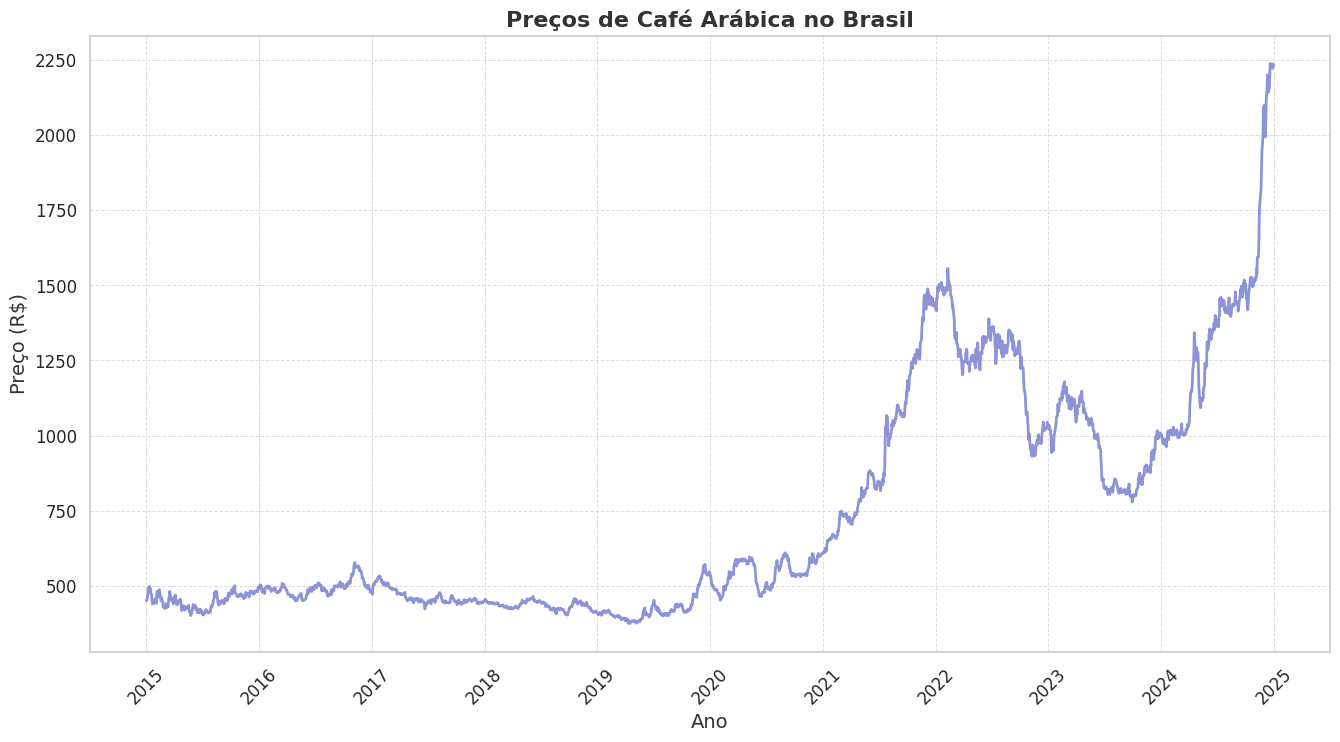

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - loss: 0.0018 - mae: 0.0285 - val_loss: 0.0078 - val_mae: 0.0793
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - loss: 1.2636e-04 - mae: 0.0082 - val_loss: 0.0012 - val_mae: 0.0260
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - loss: 9.4627e-05 - mae: 0.0074 - val_loss: 0.0015 - val_mae: 0.0316
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - loss: 9.5937e-05 - mae: 0.0074 - val_loss: 0.0026 - val_mae: 0.0450
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - loss: 1.0148e-04 - mae: 0.0076 - val_loss: 7.3072e-04 - val_mae: 0.0203
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - loss: 9.1193e-05 - mae: 0.0070 - val_loss: 0.0033 - val_mae: 0.0520
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - loss: 7.2229e-05 - mae: 0.0062 - val_loss: 4.2228e-04 - val_mae: 0.0153
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - loss: 7.4905e-05 - mae: 0.0063 - val_loss: 8.1146e-04 - val_mae: 0.0230
Epoch 9/100
49/49 ━━━━━━

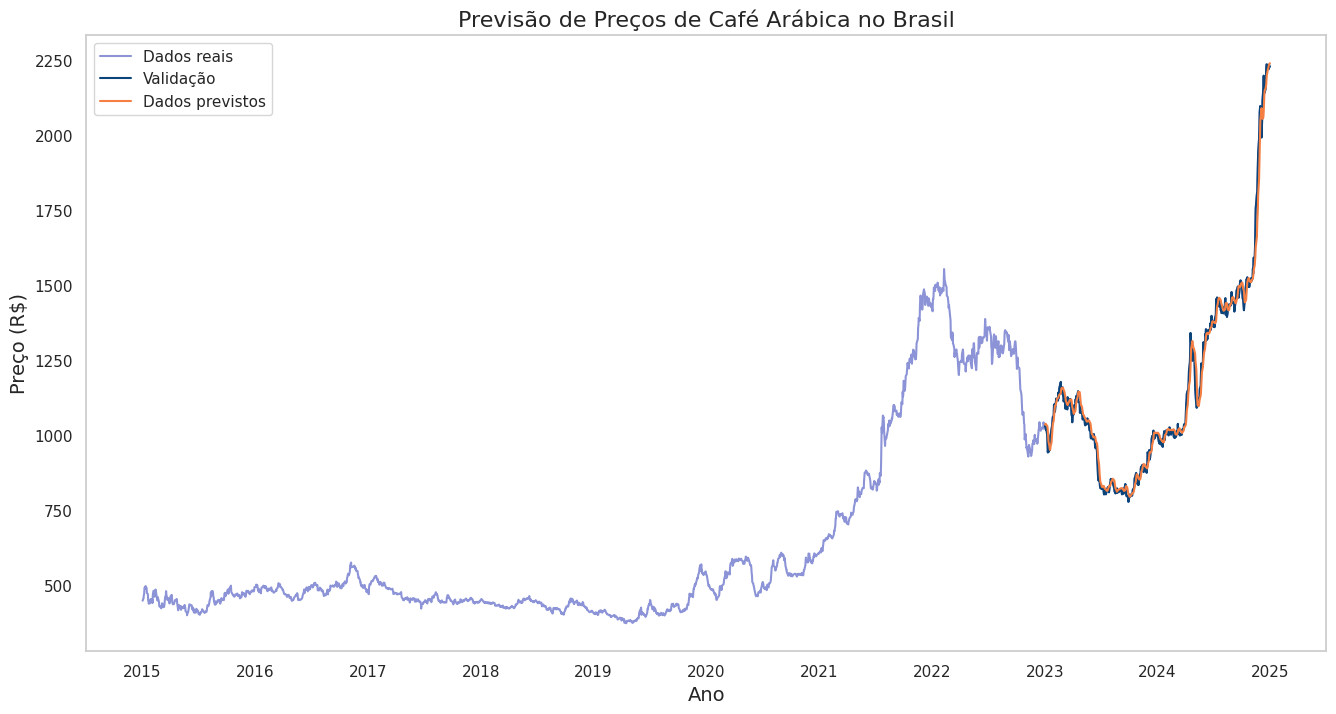

In [15]:
# Fluxo principal
# Aplicação das funções

if __name__ == "__main__":
    filepath = "/content/drive/MyDrive/CEPEA.csv"
    df = load_and_preprocess_data(filepath, '2015-01-01', '2025-01-01')

    plot_data(df)

    window_size = 60
    X_train, y_train, X_test, y_test, scaler = prepare_data(df, "preco_reais", window_size)

    model = build_lstm_model((X_train.shape[1], 1))
    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=1)

    y_pred = model.predict(X_test)
    evaluate_model(y_test, y_pred, scaler)

    train_size = int(len(df) * 0.8)
    plot_predictions(df, train_size, y_test, y_pred)